## Linear Regression

## By: Jeffrey Cabrera

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
# Import data
cols = ["ID", "LoanAmt", "IntRate", "LoanTerm", "Debt2Inc", "Home", "MonthlyInc", "FICO-Range", "RevCredBal", "EmpLen"]
loan_data = pd.read_csv("../data/loansData.csv", names=cols, index_col="ID")

In [3]:
# Display the first five values
loan_data.head()

,LoanAmt,IntRate,LoanTerm,Debt2Inc,Home,MonthlyInc,FICO-Range,RevCredBal,EmpLen
ID,,,,,,,,,
81174,20000,8.90%,36 months,14.90%,MORTGAGE,6541.67,735-739,14272.0,< 1 year
99592,19200,12.12%,36 months,28.36%,MORTGAGE,4583.33,715-719,11140.0,2 years
80059,35000,21.98%,60 months,23.81%,MORTGAGE,11500.00,690-694,21977.0,2 years
33182,12000,11.71%,36 months,18.78%,RENT,3195.00,695-699,14469.0,9 years
62403,6000,15.31%,36 months,20.05%,OWN,4891.67,670-674,10391.0,3 years


In [4]:
# Display the datatypes
loan_data.dtypes

LoanAmt         int64
IntRate        object
LoanTerm       object
Debt2Inc       object
Home           object
MonthlyInc    float64
FICO-Range     object
RevCredBal    float64
EmpLen         object
dtype: object

In [5]:
# Display the shape of the data
loan_data.shape

(1752, 9)

In [6]:
# Display the counts for loan term
loan_data["LoanTerm"].value_counts()

LoanTerm
36 months    1430
60 months     322
Name: count, dtype: int64

In [7]:
# Display the counts for the home
loan_data["Home"].value_counts()

Home
RENT        844
MORTGAGE    761
OWN         147
Name: count, dtype: int64

In [8]:
# Display the counts for EmpLen
loan_data["EmpLen"].value_counts()

EmpLen
10+ years    453
2 years      175
3 years      166
< 1 year     165
5 years      151
4 years      147
1 year       130
6 years      126
7 years      100
8 years       86
9 years       53
Name: count, dtype: int64

In [9]:
# Display the descriptive statistics
loan_data.describe()

,LoanAmt,MonthlyInc,RevCredBal
count,1752.000000,1752.000000,1752.000000
mean,11609.474886,5520.837854,13932.856164
std,7443.034671,3186.290186,13708.658521
min,1000.000000,1000.000000,0.000000
25%,6000.000000,3416.670000,5539.250000
50%,10000.000000,4833.330000,10738.500000
75%,15000.000000,6666.670000,17680.000000
max,35000.000000,39583.330000,143151.000000


In [10]:
# Let's take a look at the highest credit balance for the loan data
loan_data[loan_data["RevCredBal"] == loan_data["RevCredBal"].max()]

,LoanAmt,IntRate,LoanTerm,Debt2Inc,Home,MonthlyInc,FICO-Range,RevCredBal,EmpLen
ID,,,,,,,,,
17864,12000,8.88%,60 months,19.38%,MORTGAGE,4000.0,795-799,143151.0,4 years


## Clean the Data

In [11]:
# Strip the IntRate field of the '%' and convert to float
loan_data["IntRate"] = loan_data["IntRate"].str.strip("%").astype(float)
loan_data["IntRate"].head()

ID
81174     8.90
99592    12.12
80059    21.98
33182    11.71
62403    15.31
Name: IntRate, dtype: float64

In [12]:
# Strip the Debt2Inc field of the '%' and convert to float
loan_data["Debt2Inc"] = loan_data["Debt2Inc"].str.strip('%').astype(float)
loan_data["Debt2Inc"].head()

ID
81174    14.90
99592    28.36
80059    23.81
33182    18.78
62403    20.05
Name: Debt2Inc, dtype: float64

In [13]:
# Split the FICO-Range field into a list using '-'
# Get the first element and convert it to an integer
# Set the result to a new column name FICO-Low
loan_data["FICO-Low"] = loan_data["FICO-Range"].str.split('-').str.get(0).astype(int)
loan_data["FICO-Low"].head()

ID
81174    735
99592    715
80059    690
33182    695
62403    670
Name: FICO-Low, dtype: int64

In [14]:
# Split the FICO-Range field into a list using '-'
# Get the second element and convert to an integer
# Set the result to a new column named FICO-High
loan_data["FICO-High"] = loan_data["FICO-Range"].str.split('-').str.get(1).astype(int)
loan_data["FICO-High"].head()

ID
81174    739
99592    719
80059    694
33182    699
62403    674
Name: FICO-High, dtype: int64

In [15]:
# Calculate the mean of the two new columns and convert to an integer
loan_data["FICO"] = loan_data[["FICO-Low", "FICO-High"]].mean(axis=1).astype(int)
loan_data["FICO"].head()

ID
81174    737
99592    717
80059    692
33182    697
62403    672
Name: FICO, dtype: int64

In [16]:
# Drop the three hyphenated FICO columns
# Verifi the columns were dropped
loan_data = loan_data.drop(["FICO-Low", "FICO-Range", "FICO-High"], axis=1)
loan_data.columns

Index(['LoanAmt', 'IntRate', 'LoanTerm', 'Debt2Inc', 'Home', 'MonthlyInc',
       'RevCredBal', 'EmpLen', 'FICO'],
      dtype='object')

In [17]:
# Remove the "months" from the loan term
loan_data["LoanTerm"] = loan_data["LoanTerm"].str.split(" ").str.get(0).astype(int)
loan_data["LoanTerm"].head()

ID
81174    36
99592    36
80059    60
33182    36
62403    36
Name: LoanTerm, dtype: int64

In [18]:
# Strip the Emplen field of the '<'
# Split the field on the space and grab first element
# Strip the field of the '+' and convert to int
loan_data["EmpLen"] = loan_data["EmpLen"].str.strip('<')
loan_data["EmpLen"] = loan_data["EmpLen"].str.split().str.get(0)
loan_data["EmpLen"] = loan_data["EmpLen"].str.strip('+').astype(int)
loan_data["EmpLen"].head()

ID
81174    1
99592    2
80059    2
33182    9
62403    3
Name: EmpLen, dtype: int64

In [19]:
# Display first few rows of the dataset
loan_data.head()

,LoanAmt,IntRate,LoanTerm,Debt2Inc,Home,MonthlyInc,RevCredBal,EmpLen,FICO
ID,,,,,,,,,
81174,20000,8.90,36,14.90,MORTGAGE,6541.67,14272.0,1,737
99592,19200,12.12,36,28.36,MORTGAGE,4583.33,11140.0,2,717
80059,35000,21.98,60,23.81,MORTGAGE,11500.00,21977.0,2,692
33182,12000,11.71,36,18.78,RENT,3195.00,14469.0,9,697
62403,6000,15.31,36,20.05,OWN,4891.67,10391.0,3,672


In [20]:
# Transform the home category to dummies
# Create a set of three dummy columns
home_dum = pd.get_dummies(loan_data["Home"], prefix="Home")

In [21]:
# Create a subset of the first three predictor columns
# Join these columns to the dummy columns
loan_X1 = loan_data[["LoanAmt", "LoanTerm", "Debt2Inc"]].join(home_dum)

In [22]:
# Create a subset of the last four predictor columns
loan_X2 = loan_data[["MonthlyInc", "RevCredBal", "FICO", "EmpLen"]]

In [23]:
# Create a subset of only the response variable column
loan_Y = loan_data[["IntRate"]]

In [24]:
# Form a new loan_data dataset from the concatenation of these three subsets
loan_data = pd.concat([loan_Y, loan_X1, loan_X2], axis=1)

In [25]:
# Display the current dataset
loan_data.head()

,IntRate,LoanAmt,LoanTerm,Debt2Inc,Home_MORTGAGE,Home_OWN,Home_RENT,MonthlyInc,RevCredBal,FICO,EmpLen
ID,,,,,,,,,,,
81174,8.90,20000,36,14.90,True,False,False,6541.67,14272.0,737,1
99592,12.12,19200,36,28.36,True,False,False,4583.33,11140.0,717,2
80059,21.98,35000,60,23.81,True,False,False,11500.00,21977.0,692,2
33182,11.71,12000,36,18.78,False,False,True,3195.00,14469.0,697,9
62403,15.31,6000,36,20.05,False,True,False,4891.67,10391.0,672,3


In [26]:
# Drop the Home_MORTGAGE column
loan_data = loan_data.drop(["Home_MORTGAGE"], axis=1)
loan_data.head()

,IntRate,LoanAmt,LoanTerm,Debt2Inc,Home_OWN,Home_RENT,MonthlyInc,RevCredBal,FICO,EmpLen
ID,,,,,,,,,,
81174,8.90,20000,36,14.90,False,False,6541.67,14272.0,737,1
99592,12.12,19200,36,28.36,False,False,4583.33,11140.0,717,2
80059,21.98,35000,60,23.81,False,False,11500.00,21977.0,692,2
33182,11.71,12000,36,18.78,False,True,3195.00,14469.0,697,9
62403,15.31,6000,36,20.05,True,False,4891.67,10391.0,672,3


In [27]:
# Lets save the cleaned, preprocessed dataset
loan_data.to_csv("../data/loansDataClean.csv", index_label="ID")

## Examine the variable relationships

In [28]:
# Display the correlation coefficient matrix
loan_corr = loan_data.corr()
loan_corr

,IntRate,LoanAmt,LoanTerm,Debt2Inc,Home_OWN,Home_RENT,MonthlyInc,RevCredBal,FICO,EmpLen
IntRate,1.000000,0.308321,0.414420,0.157653,-0.007368,0.090279,0.018718,0.078770,-0.733519,0.040652
LoanAmt,0.308321,1.000000,0.370207,0.083909,-0.049427,-0.122979,0.439503,0.364792,0.060730,0.158234
LoanTerm,0.414420,0.370207,1.000000,0.015259,-0.021353,-0.035742,0.081958,0.093702,-0.011196,0.056425
Debt2Inc,0.157653,0.083909,0.015259,1.000000,0.023173,-0.009381,-0.178562,0.219052,-0.210367,0.020760
Home_OWN,-0.007368,-0.049427,-0.021353,0.023173,1.000000,-0.291776,-0.092213,-0.052714,0.003564,-0.024643
Home_RENT,0.090279,-0.122979,-0.035742,-0.009381,-0.291776,1.000000,-0.197034,-0.177969,-0.132138,-0.227581
MonthlyInc,0.018718,0.439503,0.081958,-0.178562,-0.092213,-0.197034,1.000000,0.432443,0.114587,0.095479
RevCredBal,0.078770,0.364792,0.093702,0.219052,-0.052714,-0.177969,0.432443,1.000000,0.003040,0.140526
FICO,-0.733519,0.060730,-0.011196,-0.210367,0.003564,-0.132138,0.114587,0.003040,1.000000,0.018457
EmpLen,0.040652,0.158234,0.056425,0.020760,-0.024643,-0.227581,0.095479,0.140526,0.018457,1.000000


In [29]:
# Display the labelled correlation matrix
groups = ["NegString", "NegMedium", "Weak", "PosMedium", "PosString"]
cols = list(loan_data.columns)
for col in cols:
    loan_corr[col] = pd.cut(loan_corr[col],
                              (-1, -0.7, -0.3, 0.3, 0.7, 1),
                              labels=groups)
loan_corr

,IntRate,LoanAmt,LoanTerm,Debt2Inc,Home_OWN,Home_RENT,MonthlyInc,RevCredBal,FICO,EmpLen
IntRate,PosString,PosMedium,PosMedium,Weak,Weak,Weak,Weak,Weak,NegString,Weak
LoanAmt,PosMedium,PosString,PosMedium,Weak,Weak,Weak,PosMedium,PosMedium,Weak,Weak
LoanTerm,PosMedium,PosMedium,PosString,Weak,Weak,Weak,Weak,Weak,Weak,Weak
Debt2Inc,Weak,Weak,Weak,PosString,Weak,Weak,Weak,Weak,Weak,Weak
Home_OWN,Weak,Weak,Weak,Weak,PosString,Weak,Weak,Weak,Weak,Weak
Home_RENT,Weak,Weak,Weak,Weak,Weak,PosString,Weak,Weak,Weak,Weak
MonthlyInc,Weak,PosMedium,Weak,Weak,Weak,Weak,PosString,PosMedium,Weak,Weak
RevCredBal,Weak,PosMedium,Weak,Weak,Weak,Weak,PosMedium,PosString,Weak,Weak
FICO,NegString,Weak,Weak,Weak,Weak,Weak,Weak,Weak,PosString,Weak
EmpLen,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,PosString


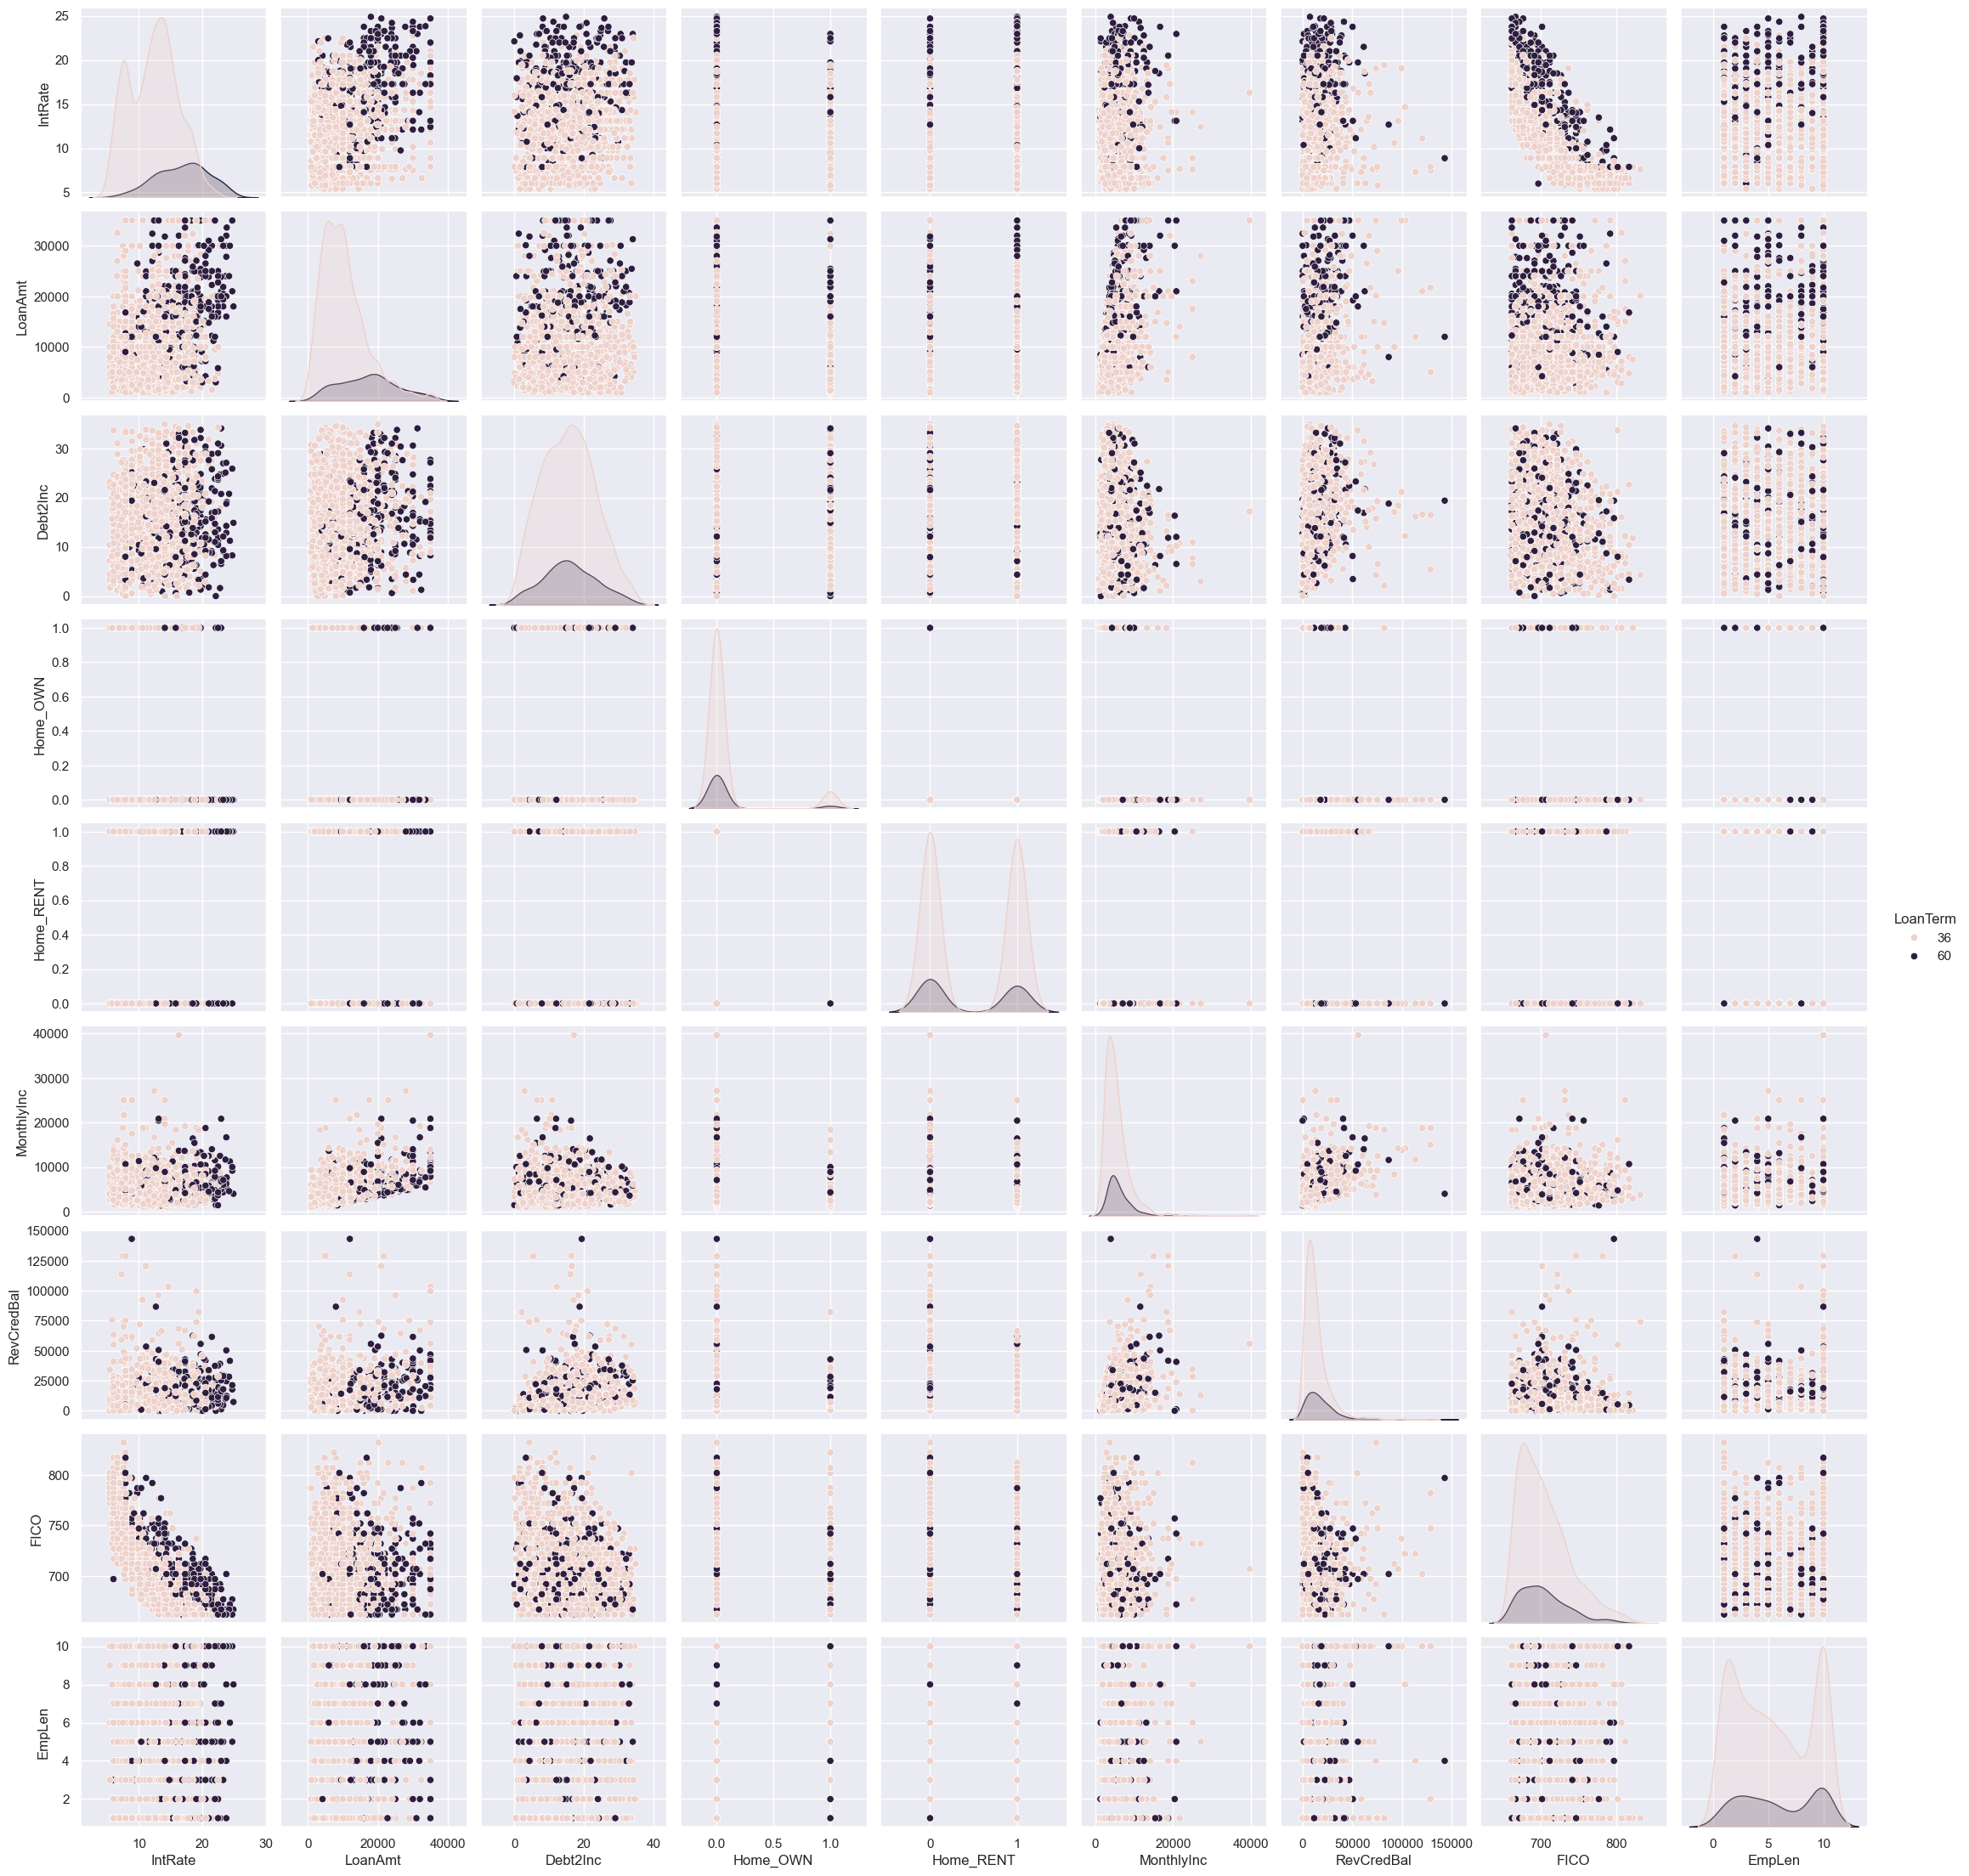

In [30]:
# Display the scatter plot matrix
sns.pairplot(loan_data, hue="LoanTerm", height=2.5)

## Running the Model with OLS From statsmodel

In [31]:
# Create DataFrame with just the response (Dependent) variable
Y = loan_data["IntRate"]
Y.head()

ID
81174     8.90
99592    12.12
80059    21.98
33182    11.71
62403    15.31
Name: IntRate, dtype: float64

In [32]:
# Create DataFrame with all predictor (Independent) variables
X = loan_data.drop(["IntRate"], axis=1)
X.head()

,LoanAmt,LoanTerm,Debt2Inc,Home_OWN,Home_RENT,MonthlyInc,RevCredBal,FICO,EmpLen
ID,,,,,,,,,
81174,20000,36,14.90,False,False,6541.67,14272.0,737,1
99592,19200,36,28.36,False,False,4583.33,11140.0,717,2
80059,35000,60,23.81,False,False,11500.00,21977.0,692,2
33182,12000,36,18.78,False,True,3195.00,14469.0,697,9
62403,6000,36,20.05,True,False,4891.67,10391.0,672,3


In [33]:
# load the standard scaler and computer the mean and standard deviation based on the training data
sc = StandardScaler()
sc.fit(X)

StandardScaler()

In [34]:
# Scale the training data to be of mean 0 and of unit variance
# Display the first 5 rows
X_std = sc.transform(X)
X_std[:5]

array([[ 1.1276208 , -0.4745259 , -0.1056352 , -0.30263639, -0.9641138 ,
         0.32047414,  0.02474645,  0.97751917, -1.32740949],
       [ 1.02010707, -0.4745259 ,  1.65831149, -0.30263639, -0.9641138 ,
        -0.29431579, -0.20378752,  0.37469848, -1.03246702],
       [ 3.14350321,  2.10736655,  1.06202936, -0.30263639, -0.9641138 ,
         1.87706358,  0.58696046, -0.37882739, -1.03246702],
       [ 0.05248351, -0.4745259 ,  0.40284275, -0.30263639,  1.03722195,
        -0.73016008,  0.03912104, -0.22812221,  1.03213033],
       [-0.75386945, -0.4745259 ,  0.56927754,  3.30429529, -0.9641138 ,
        -0.19751732, -0.25844012, -0.98164808, -0.73752454]])

In [35]:
# we will now use linear regression with its based formula of y = mx+b
# Try to reduce the independent variables with variables greater than p-value of 0.5

In [36]:
# Add a constant to the independent variable matrix to hold the y_intercept
X_std0 = sm.add_constant(X_std)

In [37]:
# Create the linear regression model using Y and X_std0
loan_model0 = sm.OLS(Y, X_std0)

In [38]:
# Fit the model to the data
loan_model0 = loan_model0.fit()

In [39]:
# The summary function produces the linear regression detailed report
"""
x1=LoanAmt
x2=LoanTerm
x3=Debt2Inc
x4=Home_OWN
x5=Home_RENT
x6=MonthlyInc
x7=RevCredBal
x8=FICO
x9=EmpLen
"""
# Note: we must print the summary() to display in pycharm
print(loan_model0.summary())

                            OLS Regression Results                            
Dep. Variable:                IntRate   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     593.6
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:27:45   Log-Likelihood:                -3771.2
No. Observations:                1752   AIC:                             7562.
Df Residuals:                    1742   BIC:                             7617.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1208      0.050    262.959      0.0

In [40]:
# Let's create a function to reduce repetitive actions
def viewOLS(X_standardScaler):
    # Add a constant to the independent variable matrix to hold the y_intercept
    X_ss = sm.add_constant(X_standardScaler)
    # Create the linear regression model using Y and X_std0
    loan_model = sm.OLS(Y, X_ss)
    # Fit the model to the data
    loan_model = loan_model.fit()
    print(loan_model.summary())

In [41]:
# The highest p-value is x9 (EmpLen)
# Drop EmpLen, x9 is index [8]
X_std1 = np.delete(X_std, [8], axis=1)
X_std1[:5]

array([[ 1.1276208 , -0.4745259 , -0.1056352 , -0.30263639, -0.9641138 ,
         0.32047414,  0.02474645,  0.97751917],
       [ 1.02010707, -0.4745259 ,  1.65831149, -0.30263639, -0.9641138 ,
        -0.29431579, -0.20378752,  0.37469848],
       [ 3.14350321,  2.10736655,  1.06202936, -0.30263639, -0.9641138 ,
         1.87706358,  0.58696046, -0.37882739],
       [ 0.05248351, -0.4745259 ,  0.40284275, -0.30263639,  1.03722195,
        -0.73016008,  0.03912104, -0.22812221],
       [-0.75386945, -0.4745259 ,  0.56927754,  3.30429529, -0.9641138 ,
        -0.19751732, -0.25844012, -0.98164808]])

In [42]:
# View the model with EmpLen removed
viewOLS(X_std1)

                            OLS Regression Results                            
Dep. Variable:                IntRate   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     667.8
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:27:45   Log-Likelihood:                -3771.6
No. Observations:                1752   AIC:                             7561.
Df Residuals:                    1743   BIC:                             7610.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1208      0.050    262.988      0.0

In [43]:
# The highest p-value is x7, x9 (RevCredBal, EmpLen)
# Drop RevCredBal, EmpLen
X_std2 = np.delete(X_std, [6, 8], axis=1)
X_std2[:5]

array([[ 1.1276208 , -0.4745259 , -0.1056352 , -0.30263639, -0.9641138 ,
         0.32047414,  0.97751917],
       [ 1.02010707, -0.4745259 ,  1.65831149, -0.30263639, -0.9641138 ,
        -0.29431579,  0.37469848],
       [ 3.14350321,  2.10736655,  1.06202936, -0.30263639, -0.9641138 ,
         1.87706358, -0.37882739],
       [ 0.05248351, -0.4745259 ,  0.40284275, -0.30263639,  1.03722195,
        -0.73016008, -0.22812221],
       [-0.75386945, -0.4745259 ,  0.56927754,  3.30429529, -0.9641138 ,
        -0.19751732, -0.98164808]])

In [44]:
# View the model with RevCredBal, EmpLen removed
viewOLS(X_std2)

                            OLS Regression Results                            
Dep. Variable:                IntRate   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     762.4
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:31:03   Log-Likelihood:                -3772.7
No. Observations:                1752   AIC:                             7561.
Df Residuals:                    1744   BIC:                             7605.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1208      0.050    262.896      0.0

In [45]:
# The highest p-value is x6, x7, x9 (Home_OWN, RevCredBal, EmpLen)
# Drop Home_OWN, RevCredBal, EmpLen
X_std3 = np.delete(X_std, [5, 6, 8], axis=1)
X_std3[:5]

array([[ 1.1276208 , -0.4745259 , -0.1056352 , -0.30263639, -0.9641138 ,
         0.97751917],
       [ 1.02010707, -0.4745259 ,  1.65831149, -0.30263639, -0.9641138 ,
         0.37469848],
       [ 3.14350321,  2.10736655,  1.06202936, -0.30263639, -0.9641138 ,
        -0.37882739],
       [ 0.05248351, -0.4745259 ,  0.40284275, -0.30263639,  1.03722195,
        -0.22812221],
       [-0.75386945, -0.4745259 ,  0.56927754,  3.30429529, -0.9641138 ,
        -0.98164808]])

In [46]:
# View the model with Home_OWN, RevCredBal, EmpLen removed
viewOLS(X_std3)

                            OLS Regression Results                            
Dep. Variable:                IntRate   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     886.4
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:32:38   Log-Likelihood:                -3775.3
No. Observations:                1752   AIC:                             7565.
Df Residuals:                    1745   BIC:                             7603.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1208      0.050    262.572      0.0

## Running the Model with PCA

In [47]:
# Create the PCA model for the top 6 principal components
pca = PCA(n_components=6)

In [48]:
# Fit the model to the data
x_pc6 = pca.fit_transform(X_std)

In [49]:
# Display the percentage of total variance for each of the first six components
pca.explained_variance_ratio_

array([0.23424274, 0.14922227, 0.14258556, 0.11378698, 0.10513131,
       0.0905952 ])

In [50]:
# Display the total percentage of total variance for each of teh first six components
sum(pca.explained_variance_ratio_)  # ~83.56% of the first six principal components

np.float64(0.8355640528804257)

In [52]:
# View the model with the six prinicipal components
viewOLS(x_pc6)

                            OLS Regression Results                            
Dep. Variable:                IntRate   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     847.0
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:41:34   Log-Likelihood:                -3805.2
No. Observations:                1752   AIC:                             7624.
Df Residuals:                    1745   BIC:                             7663.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1208      0.051    258.139      0.0

In [53]:
# First, let’s look at the p-values for each of the coefficients and the intercept. They are all zero.
# The R-squared and Adjusted R-squared values have dropped to 0.744 and the BIC value is much larger when compared with all the other models.
# So, the models produced without using PCA seem to be the best.

## Model Checking with Repeated K-Fold Cross-Validation

In [54]:
# Produce the linear model
# Use cross validation to find the model accuracy
lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X_std, Y, cv=10)
print("Mean R-Squared Score:", sum(scores)/len(scores))

Mean R-Squared Score: 0.7499651241745108


In [55]:
# Let's create a function to repeat the linear regression
def viewLR(x_standard, Y_value):
    linearModel = linear_model.LinearRegression()
    scoresValues = cross_val_score(linearModel, x_standard, Y_value, cv=10)
    print("Mean R-Squared Score:", sum(scoresValues)/len(scoresValues))

In [56]:
# Recreate standardized predictors from loan_model with EmpLen removed
X_std1 = np.delete(X_std, [8], axis=1)

In [57]:
# Display the linear model
viewLR(X_std1, Y)

Mean R-Squared Score: 0.7501118664278433


In [60]:
# Recreate standardized predictors from loan_model with EmpLen and RevCredBal removed
X_std2 = np.delete(X_std, [6, 8], axis=1)

In [61]:
# Display the linear model
viewLR(X_std2, Y)

Mean R-Squared Score: 0.7501300573369651


In [62]:
# Recreate standardized predictors from loan_model with EmpLen, RevCredBal and Home_OWN
X_std3 = np.delete(X_std, [5, 6, 8], axis=1)

In [63]:
# Display the linear model
viewLR(X_std3, Y)

Mean R-Squared Score: 0.7496697982493198


In [64]:
# Let's produce linear mode with split dataset into test and training
lm = linear_model.LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(X_std3, Y, random_state=33, test_size=0.2)

In [65]:
# Fit the model to the training data
model = lm.fit(X_train, Y_train)

In [66]:
# Produce a set of prediction from the test set and display the first five predictions
predictions = lm.predict(X_test)
predictions[:5]

array([15.469362  ,  6.56811595, 13.7424766 ,  7.63804785, 13.9728806 ])

In [67]:
# Display the R-Square score
print("R-Squared Score: ", model.score(X_test, Y_test))

R-Squared Score:  0.7824773766264431


Text(0, 0.5, 'Predictions')

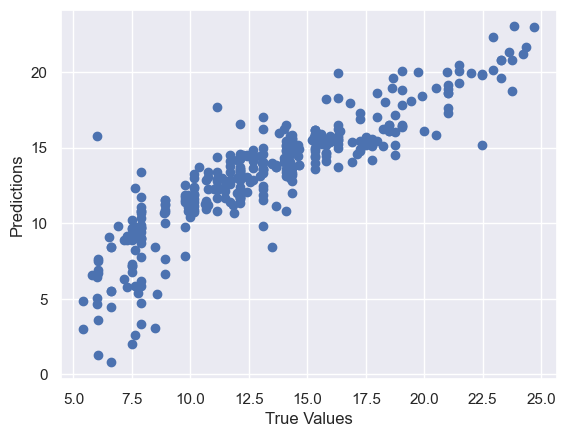

In [68]:
# Plot teh predictions versus actuals
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")